In [1]:
# # ------------------------------ ATTENTION ------------------------------ ##
# # You may need to install the nptyping package (>>> pip install nptyping)
# # for numpy type indicators
# # ====================================================================== ##

---
# Multicell Profile
---

Import of the `BeamSection` class from the `FlightBEND` package. If you cloned the ropository use the cell below in all exemples as well. 

In [15]:
import numpy as np
arr = [[1,2],[1,2],[1,2]]
np.hstack([np.zeros(np.shape(arr)), arr])

array([[0., 0., 1., 2.],
       [0., 0., 1., 2.],
       [0., 0., 1., 2.]])

In [2]:
import sys
# sys.path.append('../src')
sys.path.append('../mesh_files')

If you have the ``flightBEND`` package installed you can just use the cell below:

In [3]:
# Import BeamSection class
# from flightBEND.beam_section import BeamSection # version 1.0.0
from flightbend import BeamSection                # versions 1.0.2 and above

#### _Mesh file import._

If you wish to generate meshes like the ones from our examples, check the Mesh generation section of the ``readme.md``, but any mesh that can be formated with the expected data is valid. 

The only data that is needed be given to the `BeamSection` object are:
* a list, tuple or numpy array of node coordinate;
* a list, tuple or numpy array of element conectivity;
* a list, tuple or numpy array for each material property (values, if the section is homogeneous):
    - Young's modulus
    - Poisson's ratio
    - density

<div class="alert alert-block alert-danger">
<b>Caution:</b> In the code the cross-section is assumed to be in the YZ plane, if the node coordinates are given in 3D the X coordinates are ignored during calculations. If they are given in 2D it is assumed the pair corresponds to (Y,Z).
</div>

Below is an exemple for the multicell case. The first file is a mesh that contains 88 quadrilateral elements with 9 nodes, and the second contains 2244 to test the accuracy and efficiency of the code. More are available in the `mesh_files` folder.

In [4]:
# Mesh multicell profile mesh with distinct materials

# #88 elements
from mult_Q9_88e import dados  as data   # 1 element through thickness

# #2244 elements
# from Malhas.mult_Q9_2244e import data # 11 elements through thickness

For every example the mesh file contains the variable `dados`  which is a dictionary containing the keys ``'materials'``, ``'coordinates'`` and ``'elements'``. 
* The `materials` key contains an array of size $N_e \times 3$, $N_e$ being the number of elements in the mesh. Column 0 corresponds to the Young modulus, column 1 to Poissons ratio and column 2 to the materials density. 
* The ``'coordinates'`` key contains an array of size $N_n \times 3$ or $N_n \times 2$, $N_n$ being the number of nodes in the mesh. The coordinates are given in 3D with $X=0$;
* The ``'elements'`` key contains an array of size $N_e \times N_{\text{npe}}$, $N_{\text{npe}}$ being the number of nodes per element. Traditional Lagrange T3, T6, Q4 and Q9 elements are currently supported;

In the code below those arrays are unpacked into variables to later be passed to the `BeamSection` constructor.

In [5]:
# # 'Unpacking' the mesh data
# Mesh geometry
secNodes    = data['coordinates'] * 1e2                # Node coordinates
secElems    = data['elements']                         # Mesh Connectivity

# Material properties
secYoung    = data['materials'][:,0]                   # Modulus of elasticity
secNu       = data['materials'][:,1]                   # Poisson's ratio
secRho      = data['materials'][:,2]                   # Specific mass

#### _Creation of the cross section instance._

When creating the instance, by default, the cross-section warping problem is solved and the area and inertia properties are calculated. (see `src/FlightBEND/beam_section.py` in the `__init__` method). You can also instantiate the object without simulating by using the `noSimulation=False` flag.

By default, the time taken on the global stiffness assembly, solution of the FEM equations and integration of area properties are displayed at the end of processing. To disable use the `displayTimes = False` kwarg.


In [6]:
# Creating an instance of a BeamSection object
sec = BeamSection(coordinates   = secNodes,
                  connectivity  = secElems,
                  young         = secYoung,
                  nu            = secNu,
                  rho           = secRho,
                  intDegree     = 4,
                  displayTimes  = True,
    )
# 'intDegree' is the gaussian quadrature degree for area integration, 
# the higher the degree, the higher the number of integration points and accuracy, 
# but more computational effort required

Area properties integration time:    0.074 seconds
Global stiffness assembly time:      0.206 seconds
System solve time:                   0.001 seconds
Shear center integration time:       0.104 seconds
Torsional constant integration time: 0.092 seconds


Plotting the cross-section with material distribuition and gauss points:

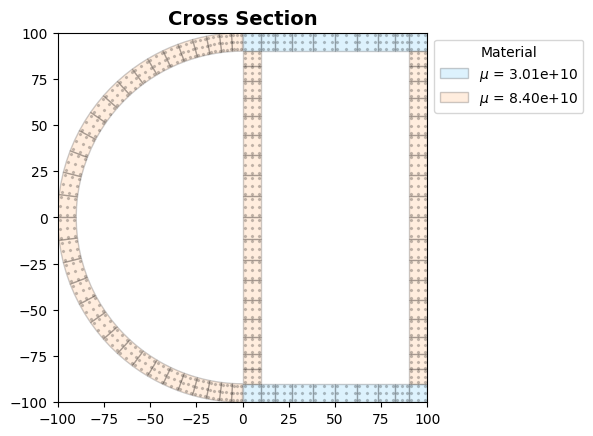

In [7]:
fig, ax = sec.plotSection(showElemLabel=False,showNodeLabel=False, showGaussPoints=True)

Printing some results:

In [8]:
# Use the getAreaProperties() method to acess the area properties dictionary. 
# Use the getMassProperties() method to acess the area mass properties dictionary. 
areaProps = sec.getAreaProperties()
for key, val in areaProps.items():
    print(f'{key:>30}: {val: 10.4e}')

                           A_w:  1.9284e+04
                          Qy_w:  9.8241e+04
                          Qz_w: -1.0355e+00
                         Iyy_w:  8.4958e+07
                         Izz_w:  7.9032e+07
                         Iyz_w:  4.4000e+01
                        Y_CG_w:  5.0943e+00
                        Z_CG_w: -5.3695e-05
                    Iyy_w_cent:  8.4457e+07
                    Izz_w_cent:  7.9032e+07
                    Iyz_w_cent:  4.9275e+01
                          Y_CT: -2.4559e+00
                          Z_CT: -1.0055e-04
                          c_CT: -3.4605e+03
                         J_phi:  6.3227e+07
                     J_phi_w_G:  1.2372e+08
                     Qy_cent_w:  2.1464e-10
                     Qz_cent_w:  3.9790e-13


In [9]:
# Explanation of each key in the areaProperties dict
help(sec.getAreaProperties)

Help on method getAreaProperties in module flightbend.beam_section:

getAreaProperties() -> dict[str, float] method of flightbend.beam_section.BeamSection instance
    Gets the area properties of the section. 
    
    Note: The reference moduli are always taken to be the first entry on the material properties lists (E0 = E[0], G0 = G[0])
    
    Returns
    -------
    areaProps : dict
        Dictionary of area properties.
        
    | Key           | Description                                                                                                                                   | Dimension         
    |------------   |---------------------------------------------------------------------------------------------------------------------------------------        |-------------  
    | A_w           | Weighted Area (∫(E/E0)dA). Area weighted by the ratio of the elastic modulus to a reference modulus (E0).                                     | L^2           
    | Qy_w    

#### _Plotting the warping funtion and shear stress distribuitions_
All plotting functions return the ``matplotlib.figure.Figure`` and ``matplotlib.axes.Axes`` objects for further custumization, if desired (import of `matplotlib.pyplot` is needed). 

Distribution of the warping function, position of shear center and centroid (both modulus-weighted):

<div class="alert alert-block alert-success">
<b>Info:</b> Color plot is extrapolated from the nodal values via the `matplolib.pyplot.tricontourf` function.
</div>


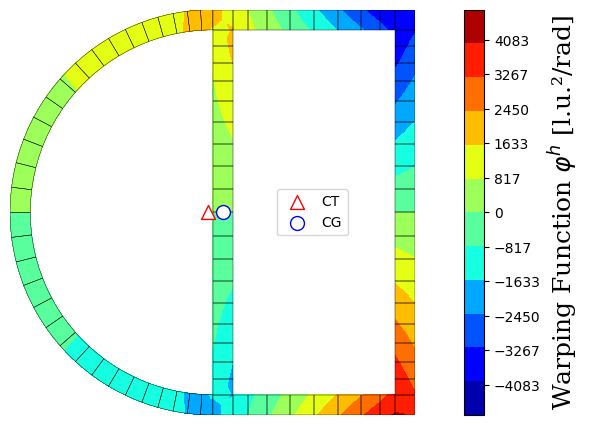

In [10]:
fig, ax = sec.plotWarping(levels=12, showMesh=True, unit='mm', figsize=(10,5))
ax.axis('off')
ax.get_legend().set_bbox_to_anchor([.85,.5])
# CT is the modulus weighted Center of Torsion (aka the shear center)
# CG is the modulus weighted Center of Gravity (aka the centroid)

Shear stress distribution (as vector field)

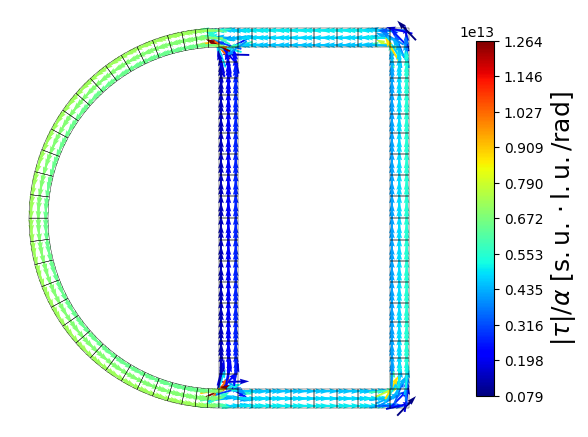

In [11]:
fig2, ax2 = sec.plotShearStresses(degree=4, 
                                  width=1,scale=.07, headlength=5, 
                                  figsize=(10,5), 
                                  cbarKwargs=dict(shrink=.85)
                                  )

ax2.axis('off')
print('')

Shear stress distribution (as component-wise scalar fields). 


<div class="alert alert-block alert-success">
<b>Important:</b> Empty spaces appear because the stresses are calculated at <i>Gauss points</i> and <b>not at nodes</b>. This is done to prevent graphical issues arising from discontinuities between elements, since the stress field is not guaranteed to be C^0 continuous. Better results could be achieved by the implementation of a stress recovery routine.
</div>
 

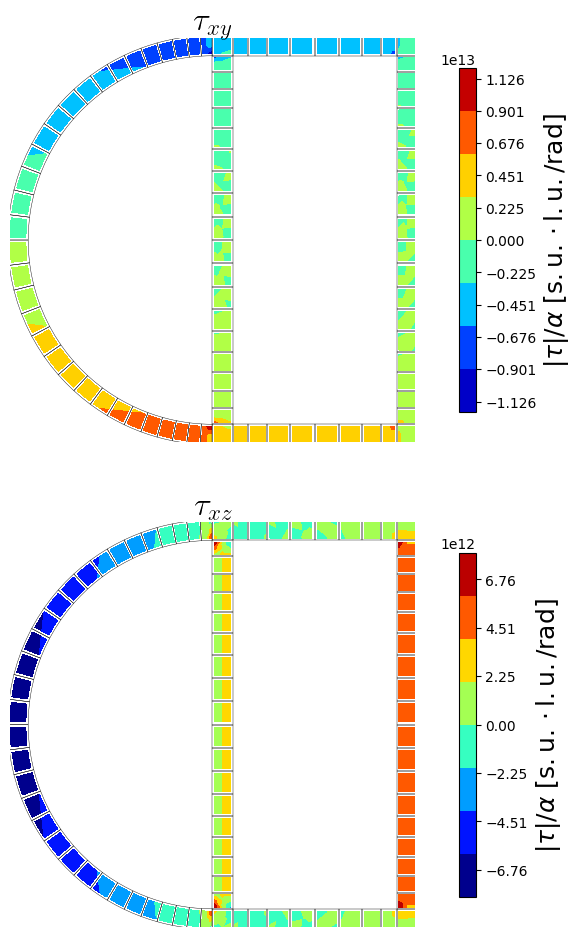

In [12]:
## Shear stresses (component wise scalar fields)
fig3, ax3 = sec.plotShearStresses(degree=4, mode='scalar',showMesh=True,
                                  figsize=(12,5), 
                                  cbarKwargs=dict(shrink=.85)
                                  )
fig3.tight_layout()
# Remove axis frame 
{ax.axis('off') for ax in ax3}
print('')